In [2]:
import sys
import numpy as np
import pandas as pd
from itertools import compress

**Methods For Preprocessing**

In [3]:
def validate_sequence(input_sequence):
  """ 
  Checks whether an input only contains valid nucleotides.
  Returns input string as a list of capitalized nucleotides if valid
  """
  valid_chars = ['A', 'U', 'C', 'G']
  input_sequence = input_sequence.strip()
  input_sequence = [c.upper() for c in input_sequence]

  for char in input_sequence:
    if char not in valid_chars:
      return False
  return input_sequence

In [ ]:
validate_sequence("augcuGGGCCCU")

['A', 'U', 'G', 'C', 'U', 'G', 'G', 'G', 'C', 'C', 'C', 'U']

In [ ]:
validate_sequence("invalidsequence")

False

**Methods for Nussinov Implementation**

In [65]:
def get_base_pairing_score(v_i, v_j):
  """Returns 1 if input nucleotides form a chemical bond."""
  pairs = [('A','U'), ('U', 'A'), ('G', 'C'), ('C', 'G')]
  two_bond = [('A', 'U'), ('U', 'A')]
  three_bond = [('G', 'C'), ('C', 'G')]
#   if (v_i, v_j) in two_bond:
#     return 1
#   elif (v_i, v_j) in three_bond:
#     return 2
  if (v_i, v_j) in pairs:
      return 1
  return 0

In [5]:
def fill_dp_table(rna_strand, hairpin_loop_min):
  """
  Fills out DP table that corresponds to optimal scoring of input sequence.

  Parameters
  ----------
  rna_strand : list of n chararacters
      valid all caps sequence of nucleotides
  hairpin_loop_min : int
      minimum length of hairpin loops

  Returns
  -------
  dp_table : 2-D list
      n x n table containing Nussinov scores between indices
  max_score: int
      maximum amount of valid pairings possible in secondary structure

  """
  n = len(rna_strand)
  
  dp = [[0 for _ in range(n)] for _ in range(n)] # initialize nxn table with zeroes

  # iterate through table diagonally
  for x in range(1, n):
    for i in range(0, n - x):
      if i == 0:
        j = x 
      else:
        j += 1
      # if distance between i and j is enough, check 4 possible cases and choose maximum
      if (j - i > hairpin_loop_min): # we want hairpin loops with this length or more
        i_j_paired = dp[i + 1][j - 1] + get_base_pairing_score(rna_strand[i], rna_strand[j])
        i_unpaired = dp[i + 1][j]
        j_unpaired = dp[i][j -1]
        bifurcation = max([dp[i][k] + dp[k + 1][j] for k in range (i, j)])

        dp[i][j] = max(i_j_paired, i_unpaired, j_unpaired, bifurcation)

  return dp, dp[0][n - 1]   # (0, n - 1) contains overall max score

In [6]:
def traceback(rna_strand, dp_table):
  """
  Backtraces input DP table to generate a list of RNA secondary structure index pairings.

  Parameters
  ----------
  dp_table : 2-D list
      n x n table containing Nussinov scores between indices

  Returns
  -------
  paired_indices: list of integer tuples
      set of indices in the original RNA strand 
      that are paired together in optimal secondary structure

  """
  n = len(dp_table)
  paired_indices = [] # list containing which indices i, j in rna_strand are paired
  stack = []
  stack.append((0, n - 1))  # (0, n - 1) instead of (1, n) to stay within index bounds
  while (len(stack) > 0):
    pair = stack.pop()
    i = pair[0]
    j = pair[1]

    if (i >= j):
      continue
    elif (dp_table[i + 1][j] == dp_table[i][j]): # i is unpaired
      stack.append((i + 1, j))
    elif (dp_table[i][j - 1] == dp_table[i][j]): # j is unpaired
      stack.append((i, j - 1))
    elif (dp_table[i + 1][j - 1] + 1 == dp_table[i][j] and get_base_pairing_score(rna_strand[i], rna_strand[j]) == 1): # we have a pairing
      paired_indices.append((i, j))  # add to paired indices list
      stack.append((i + 1, j - 1))
    else:
      for k in range(i + 1, j): # last element is j - 1
        if (dp_table[i][k] + dp_table[k + 1][j] == dp_table[i][j]): # bifurcation
          stack.append((k + 1, j))
          stack.append((i, k))
          break
  return paired_indices


In [7]:
def nussinov(rna_strand, loop_parameter):
  """
  Executes Nussinov Algorithm to predict optimal secondary structure of input RNA strand.

  Parameters
  ----------
  rna_strand : str
      1-D RNA structure
  loop_parameter : int
      minimum length of hairpin loops, zero by default

  Returns
  -------
  dp_table : 2-D list
      n x n table containing Nussinov scores between indices
  max_score: int
      maximum amount of valid pairings possible in secondary structure
  pairings: list of integer tuples
      set of indices in the original RNA strand 
      that are paired together in optimal secondary structure
  dash_structure: str
      represendation of RNA 2-D structure

  """
  rna_strand = validate_sequence(rna_strand)
  dp_table, max_score = fill_dp_table(rna_strand, loop_parameter)
  pairings = traceback(rna_strand, dp_table)
  dash_structure = format_pairings(rna_strand, pairings)
  return dp_table, max_score, pairings, dash_structure

**Methods for Postprocessing**

In [8]:
from tabulate import tabulate
pdtabulate=lambda df:tabulate(df,headers='keys',tablefmt='psql')

def print_nussinov_output_nicely(rna_strand, loop_parameter, dp_table, max_score, dash_output):
  sys.stdout.write("INPUT RNA STRAND: " + rna_strand + "\n")
  sys.stdout.write("MINIMUM LOOP LENGTH: " + str(loop_parameter) + "\n")
  sys.stdout.write("OPTIMAL SECONDARY STRUCTURE: " + dash_output + "\n")
  sys.stdout.write("MAXIMAL NUMBER OF NUCLEOTIDE PAIRINGS: " + str(max_score) + "\n")
  sys.stdout.write("DP TABLE: " + "\n\n")
  df = pd.DataFrame.from_records(dp_table)
  print(pdtabulate(df))


In [9]:
def format_pairings(rna_strand, paired_indices_list):
  """Generates a represendation of RNA 2-D structure given optimal base pairings."""
  formatted = ['-' for i in range(len(rna_strand))] # initialize everything with dashes
  for pair in paired_indices_list:
    formatted[pair[0]] = "("
    formatted[pair[1]] = ")"
  return " ".join(formatted)

**Methods for Testing**

In [10]:
def check_valid_pairings(input_rna, secondary_str_pairings):
  """Given a predicted 2D structure, check that A only bonds w/ U and C only bonds w/ G"""
  for pair in secondary_str_pairings:
    base_1 = input_rna[pair[0]]
    base_2 = input_rna[pair[1]]
    if get_base_pairing_score(base_1, base_2) != 1:
      print(base_1, base_2)
      return False
  return True

In [11]:
check_valid_pairings("CC", [(0, 1)])

C C


False

In [ ]:
check_valid_pairings("AU", [(0, 1)])

True

In [12]:
def check_pseudoknots(secondary_str):
  """ 
  Checks whether a set of pairings in RNA secondary structure contains pseudoknots.
  Returns False if no pseudoknots, True otherwise
  """
  # pairwise iteration through list of pairings
  pairwise_groupings = list(zip(secondary_str, secondary_str[1:] + secondary_str[:1])) 
  for two_pairs in pairwise_groupings:
    i = two_pairs[0][0]
    j = two_pairs[0][1]
    i_prime = two_pairs[1][0]
    j_prime = two_pairs[1][1]

    # pseudoknot detected
    if (i < i_prime < j < j_prime) or (i_prime < i < j_prime < j):
      return True

  return False

In [ ]:
check_pseudoknots([(1, 4), (2, 3)]) # (()) (nested)

False

In [ ]:
check_pseudoknots([(1, 5), (3, 9)]) #(-(-)---)

True

In [13]:
def compute_min_loop_dist(secondary_structure):
  """Return minimum distance between base pairs given dashed secondary structure"""
  no_spaces = secondary_structure.replace(" ", "")
  n = len(no_spaces)
  min_dist = n + 1 # upper bound on min distance

  base_1 = no_spaces.find('(')

  for i in range(base_1, n):
    if no_spaces[i] == '(':
      base_1 = i
    elif no_spaces[i] == ')' and (i - base_1 < min_dist):
      min_dist = i - base_1 - 1       
  return min_dist 



In [ ]:
compute_min_loop_dist("(((((((--(---)))))))))")

3

In [71]:
def compare_single_sample(input_strand, expected_dot_dash):
  """
  Compare secondary structure and score generated by our implementation 
  with a benchmark for a single input strand.
  """
  dp, m_score, pairs, predicted_structure = nussinov(input_strand, 4)
  reference_score = get_reference_score(expected_dot_dash)
  check_for_knots = check_pseudoknots(pairs)
  our_min_loop_dist = compute_min_loop_dist(predicted_structure)
  paper_min_loop_dist = compute_min_loop_dist(expected_dot_dash)
  sys.stdout.write("INPUT RNA STRAND: " + input_strand + "\n")
  sys.stdout.write("EXPECTED 2D STRUCTURE: " + " ".join(expected_dot_dash) + "\n")
  sys.stdout.write("OUR PREDICTED 2ND STR: " + predicted_structure + "\n")
  sys.stdout.write("NUMBER OF PAIRINGS IN BENCHMARK DATASET: " + str(reference_score) + "\n")
  sys.stdout.write("NUMBER OF PAIRINGS PREDICTED IN OUR IMPLEMENTATION: " + str(m_score) + "\n")
  sys.stdout.write("MIN LOOP DISTANCE IN BENCHMARK DATASET: " + str(paper_min_loop_dist) + "\n")
  sys.stdout.write("MIN LOOP DISTANCE IN OUR IMPLEMENTATION: " + str(our_min_loop_dist) + "\n")
  sys.stdout.write("PAIRINGS VALID: " + str(check_valid_pairings(input_strand, pairs)) + "\n")
  sys.stdout.write("PSEUDOKNOTS PRESENT: " + str(check_for_knots) + "\n\n")


In [15]:
def get_reference_score(s):
    """Return number of pairings given secondary structure"""
    counter = 0
    s = [c for c in s]
    for c in s:
        if c == '(': # each open parenthesis corresponds to a pairing
            counter += 1
          
    return counter

**Results of Our Implemntation VS Benchmark Data Outputs**

In [16]:
input = 'GUUUCCAUCCCCGUGAGGGGAAUAAGUGUUUUGAA'
# input = 'AUCAUAACCGUUCAGGUAACCGCUGCAUCGCAUGCGAUGU'
loop_len = 4
dp, ms, pairs, final = nussinov(input, loop_len)
print_nussinov_output_nicely(input, loop_len, dp, ms, final)
print(check_valid_pairings(input, pairs))


INPUT RNA STRAND: GUUUCCAUCCCCGUGAGGGGAAUAAGUGUUUUGAA
MINIMUM LOOP LENGTH: 4
OPTIMAL SECONDARY STRUCTURE: - - ( ( - ( - ( ( ( ( ( - - - - ) ) ) ) ) ( - ( ( - - - - ) ) ) ) ) )
MAXIMAL NUMBER OF NUCLEOTIDE PAIRINGS: 11
DP TABLE: 

+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|    |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |   25 |   26 |   27 |   28 |   29 |   30 |   31 |   32 |   33 |   34 |
|----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------|
|  0 |   0 |   0 |   0 |   0 |   0 |   1 |  

In [104]:
benchmark_data = "../data/S-Full-Train.txt"
test_file = open(benchmark_data, "r")
file_as_list = test_file.readlines()
n_samples = 30

for i in range(0, 5*n_samples, 5): # iterate through n test samples
  original_strand = file_as_list[i + 1].strip()
  original_strand = original_strand.upper()
  paper_secondary_structure = file_as_list[i + 2].strip() # given to us from the paper
  dp, m_score, pairs, predicted_structure = nussinov(original_strand, 5)
  reference_score = get_reference_score(paper_secondary_structure)
  check_for_knots = check_pseudoknots(pairs)
  our_min_loop_dist = compute_min_loop_dist(predicted_structure)
  paper_min_loop_dist = compute_min_loop_dist(paper_secondary_structure)
    
  sys.stdout.write("INPUT RNA STRAND: " + original_strand + "\n")
  sys.stdout.write("NUMBER OF PAIRINGS IN BENCHMARK DATASET: " + str(reference_score) + "\n")
  sys.stdout.write("NUMBER OF PAIRINGS PREDICTED IN OUR IMPLEMENTATION: " + str(m_score) + "\n")
  sys.stdout.write("MIN LOOP DISTANCE IN BENCHMARK DATASET: " + str(paper_min_loop_dist) + "\n")
  sys.stdout.write("MIN LOOP DISTANCE IN OUR IMPLEMENTATION: " + str(our_min_loop_dist) + "\n")
  sys.stdout.write("PAIRINGS VALID: " + str(check_valid_pairings(original_strand, pairs)) + "\n")
  sys.stdout.write("PSEUDOKNOTS PRESENT: " + str(check_for_knots) + "\n\n")


INPUT RNA STRAND: GAGGAAAGUCCCGCCUCCUGGCCUAAAGGAGUCUCUAUAGAGACAAGGGCAACACCCUUGGCAACUAUACAGAAACAAGUACCUUGAAAGCUACAUGUGAAAAUGAUUGUGCCCCUUCCUCUGGUAACGGAGGAAGAAACAUGAGAGUAGCUUUCAAGGAUGAAAAGAUAGACCUCCUAGGAGCAAGUAGAGGGAAAGAUGAGACUAGGCCCGAUUUCCCUCUAGGACGCAUAGCCAAAUCCCCCAACCAUUACAAAAGCGGGCUUA
NUMBER OF PAIRINGS IN BENCHMARK DATASET: 65
NUMBER OF PAIRINGS PREDICTED IN OUR IMPLEMENTATION: 90
MIN LOOP DISTANCE IN BENCHMARK DATASET: 4
MIN LOOP DISTANCE IN OUR IMPLEMENTATION: 5
PAIRINGS VALID: True
PSEUDOKNOTS PRESENT: False

INPUT RNA STRAND: GAGGAAAGUCCGGGCUCCAUAGGGCAGAGUGCCAGGUAACGCCUGGGAGGCGUGAGCCUACGGAAAGUGCCACAGAAAACAACCGCCUAAGUGCGCAAGCGCCGGUAAGGGUGAAAAGGUGCGGUAAGAGCGCACCGCACGGCUGGCAACAGUCCGUGGCUAGGUAAACCCCACUCGGAGCAAGACCAAAUAGGGAUCCGUUGGCGUGGCCCGCGCUGGAUCCGGGUAGGUUGCUAGAGGCGGCCAGCGAUGGUCGUCGUAGAGGAAUGACUGUCCUCGACAGAACCCGGCUUA
NUMBER OF PAIRINGS IN BENCHMARK DATASET: 81
NUMBER OF PAIRINGS PREDICTED IN OUR IMPLEMENTATION: 97
MIN LOOP DISTANCE IN BENCHMARK DATASET: 5
MIN LOOP DISTANCE IN OUR IM

KeyboardInterrupt: 

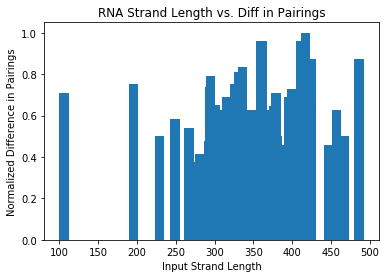

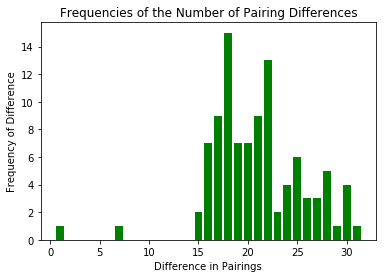

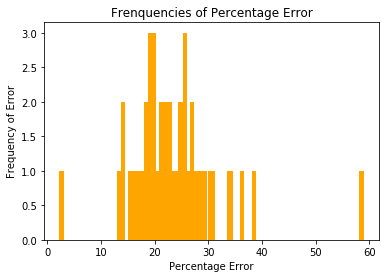

In [135]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import statistics

benchmark_data = "../data/S-Full-Train.txt"
test_file = open(benchmark_data, "r")
file_as_list = test_file.readlines()
n_samples = 100
ref_score = []
imp_score = []

input_strand_length = defaultdict(list)
diff_pairing_score = defaultdict(int)
percentage_error = defaultdict(int)


for i in range(0, 5*n_samples, 5): # iterate through n test samples
  original_strand = file_as_list[i + 1].strip()
  original_strand = original_strand.upper()
  paper_secondary_structure = file_as_list[i + 2].strip() # given to us from the paper
  dp, m_score, pairs, predicted_structure = nussinov(original_strand, 5)
  reference_score = get_reference_score(paper_secondary_structure)
  check_for_knots = check_pseudoknots(pairs)
  our_min_loop_dist = compute_min_loop_dist(predicted_structure)
  paper_min_loop_dist = compute_min_loop_dist(paper_secondary_structure)
    
  ref_score.append(int(reference_score))
  imp_score.append(int(m_score))
    
  input_sequence_length = original_strand.strip()
  input_sequence_length = [c.upper() for c in input_sequence_length]
  input_sequence_length = len(input_sequence_length)
  input_strand_length[input_sequence_length].append(diff_pairings)


  diff_pairings = abs(m_score-reference_score)
  diff_pairing_score[diff_pairings] += 1
    
  error = abs((m_score - reference_score) / (float(reference_score))) * 100
  percentage_error[error] += 1

    
normalized_scores = defaultdict(list)
avg_scores = defaultdict(float)
for key, values in input_strand_length.items():
    avg_scores[key] = statistics.mean(values)

min_value = (min(avg_scores.items(), key=lambda x: x[1]) )[1]
max_value = (max(avg_scores.items(), key=lambda x: x[1]) )[1]

for key, values in avg_scores.items():
    normalized_scores[key] = (values - min_value) / (float(max_value-min_value))
    
lengths = list(normalized_scores.keys())
normalized_diff_scores = list(normalized_scores.values())



plt.bar(*zip(*normalized_scores.items()), width=12)
plt.title(label="RNA Strand Length vs. Diff in Pairings")
plt.xlabel('Input Strand Length')
plt.ylabel('Normalized Difference in Pairings')
plt.show()




diff_pair = diff_pairing_score.keys()
diff_freq = diff_pairing_score.values()
plt.bar(list(diff_pair), list(diff_freq), color='g')
plt.title(label="Frequencies of the Number of Pairing Differences")
plt.xlabel('Difference in Pairings')
plt.ylabel('Frequency of Difference')
plt.show()




error = percentage_error.keys()
frequency = percentage_error.values()
plt.bar(list(error), list(frequency), color='orange')
plt.title(label="Frenquencies of Percentage Error")
plt.xlabel('Percentage Error')
plt.ylabel('Frequency of Error')
plt.show()


In [72]:
strand = 'CUUUCCACACUAUUUAGUUCUACGGAAAC'
expected = '.(((((..(((....))).....))))).'
compare_single_sample(strand, expected)

INPUT RNA STRAND: CUUUCCACACUAUUUAGUUCUACGGAAAC
EXPECTED 2D STRUCTURE: . ( ( ( ( ( . . ( ( ( . . . . ) ) ) . . . . . ) ) ) ) ) .
OUR PREDICTED 2ND STR: - ( ( ( ( ( ( - ( ( ( - - - - ) ) ) ) - - - - ) ) ) ) ) -
NUMBER OF PAIRINGS IN BENCHMARK DATASET: 8
NUMBER OF PAIRINGS PREDICTED IN OUR IMPLEMENTATION: 9
MIN LOOP DISTANCE IN BENCHMARK DATASET: 4
MIN LOOP DISTANCE IN OUR IMPLEMENTATION: 4
PAIRINGS VALID: True
PSEUDOKNOTS PRESENT: False

